In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import talib
import statsmodels.api as sm
# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.arima_model import ARMA 
from sklearn.svm import LinearSVC
from sklearn import linear_model

In [2]:
df = pd.read_csv('fullsetmatrix1.csv', index_col='Time')
df.index = pd.to_datetime(df.index)
print(df.head())
n_row, n_col = df.shape
# print(f'There are {n_row} rows and {n_col} columns')


                     Unnamed: 0     bch      btc     eth    ltc      xpr
Time                                                                    
2018-08-15 18:45:00           0     NaN      NaN  297.56    NaN      NaN
2018-08-15 18:46:00           1     NaN  6547.42  297.81    NaN  0.29083
2018-08-15 18:47:00           2     NaN  6549.43  297.82    NaN  0.29084
2018-08-15 18:48:00           3     NaN  6547.86  298.37    NaN  0.29010
2018-08-15 18:49:00           4  529.41  6534.95  297.94  58.07  0.29084


As we've already Identified previously, we have to deal with missing values (NaN) within our dataset. In our correlation analysis, we had backfilled our values. This time, let's follow a linear replacement method using the interpolate method(linear) that identifies all missing values and fills the values (a visualization will help make this clear) based on a linear path. We can also interpolate equivalent to the backfill method using # Interpolate using
interpolation_type = 'zero'.


In [3]:
def interpolate_and_plot(df, interpolation):

    # boolean mask for missing values
    missing_values = df.isna()

    # Interpolating missing values
    prices_interp = df.interpolate(interpolation)

    # plot while highlighting the interpolated values in black
    fig, ax = plt.subplots(figsize=(10, 5))
    prices_interp.plot(color='k', alpha=.6, ax=ax, legend=False)
    
    # plot while interpolated values on top in red
    prices_interp[missing_values].plot(ax=ax, color='r', lw=3, legend=False)
    plt.show()

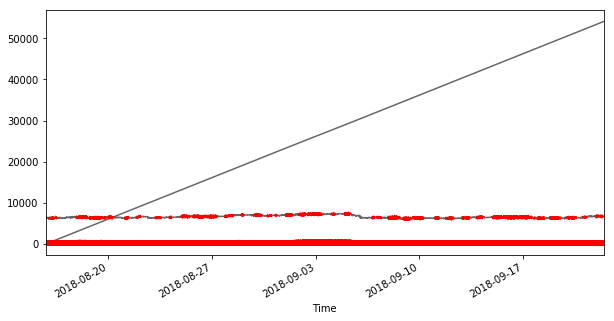

                     Unnamed: 0         bch      btc         eth        ltc  \
Time                                                                          
2018-08-15 18:45:00           0         NaN      NaN  297.560000        NaN   
2018-08-15 18:46:00           1         NaN  6547.42  297.810000        NaN   
2018-08-15 18:47:00           2         NaN  6549.43  297.820000        NaN   
2018-08-15 18:48:00           3         NaN  6547.86  298.370000        NaN   
2018-08-15 18:49:00           4  529.410000  6534.95  297.940000  58.070000   
2018-08-15 18:50:00           5  529.460000  6538.21  297.800000  58.090000   
2018-08-15 18:51:00           6  529.156000  6542.46  297.400000  57.850000   
2018-08-15 18:52:00           7  528.852000  6536.41  297.680000  57.940000   
2018-08-15 18:53:00           8  528.548000  6534.12  297.453333  58.030000   
2018-08-15 18:54:00           9  528.244000  6533.92  297.226667  57.925000   
2018-08-15 18:55:00          10  527.940000  6519.39

In [4]:
# linear interpolation type
interpolation_type = 'linear'
interpolate_and_plot(df, interpolation_type)

# boolean mask for missing values
missing_values = df.isna()

# Interpolating with missing values
df = df.interpolate('linear')
print(df.head(30))

In continuation of using Bitcoin and Litecoin from our correlation methods, lets visualize a scatterplot with color relating to time, encoding time as the color of each datapoint. Bitcoin and Litecoin have drastically varying coin values, so we expect to yield interesting results and scale the y-axis. When not comparing coins, the Bitcoin data will be used as it is the most popular and expensive currency. 

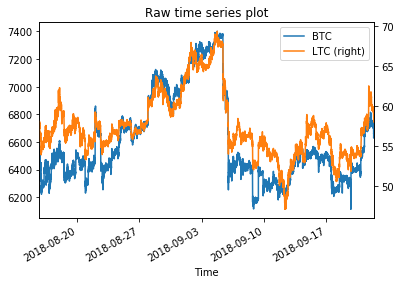

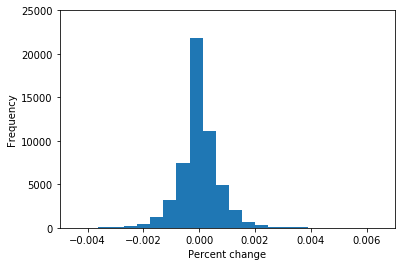

In [5]:
# Raw time series plot of bitcoin and litecoin
df['btc'].plot(label='BTC', legend=True)
df['ltc'].plot(label='LTC', legend=True, secondary_y=True)
plt.title('Raw time series plot')
plt.show() 
plt.clf() 

# Histogram of the daily price change percent 
df['btc'].pct_change().plot.hist(bins=80)
plt.axis([-.005,.007,0,25000])
plt.xlabel('Percent change')
plt.show()

Above we can see a nearly normal distribution. Although we've done correlation analysis already, let's use Pearson's correlation coefficient to detect any linear relationships. We'll check the correlations between current price changes to see if previous price changes can predicture future ones. Below, based on the outputted correlation matrix between 5 day percentage changes (current and future), we can discern a slighly negative correlation (-0.0225) to the change in the last 5 days, an example of mean reversion (stock prices bounce around as opposed to following an upward trend).

                 5min_pct  5min_future_pct
5min_pct         1.000000        -0.022466
5min_future_pct -0.022466         1.000000


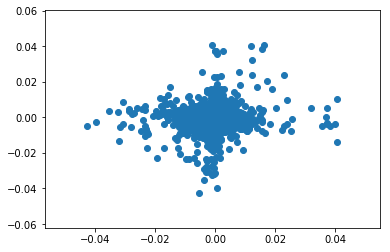

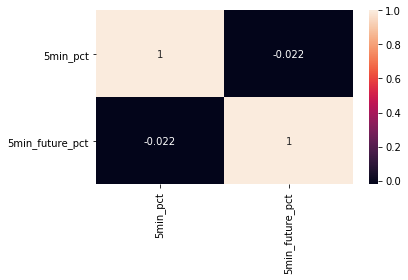

<Figure size 432x288 with 0 Axes>

In [6]:
# 5-min % price changes for the current day, and 5 min in the future
df['5min_future'] = df['btc'].shift(-5)
df['5min_future_pct'] = df['5min_future'].pct_change(5)
df['5min_pct'] = df['btc'].pct_change(5)

# correlation matrix between 5-min percentage changes (current and future)
corr = df[['5min_pct', '5min_future_pct']].corr()
print(corr)

# Scatter plot for current 5-day percent change vs the future 5-day percent change
plt.scatter(df['5min_pct'], df['5min_future_pct'])
plt.show()

# heatmap of correlation matrix
sns.heatmap(corr, annot=True)
plt.yticks(rotation=0); plt.xticks(rotation=90)  
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  
plt.clf() 

Matrix and scatter plot show almost no correlation but let's now shift 15, 30, an hour, and even 200 minutes into our dataset to see what interesting correlations exist.

In [7]:
feature_names = ['5min_pct'] 

# moving averages and rsi for timeperiods of 15, 30, 60, and 200 minutes 
# This analysis would improve when working with days or weeks versus minutes
for n in [15, 30, 60, 200]:

    # Create the moving average indicator 
    df['ma' + str(n)] = talib.SMA(df['bch'].values,
                              timeperiod=n) / df['bch']
    # Create the RSI indicator
    df['rsi' + str(n)] = talib.RSI(df['bch'].values, timeperiod=n)
    
    # Add rsi and moving average to the feature name list
    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]
    
print(feature_names)

['5min_pct', 'ma15', 'rsi15', 'ma30', 'rsi30', 'ma60', 'rsi60', 'ma200', 'rsi200']


In [8]:
# Drop all nan values
df = df.dropna()

# features and targets
# use feature_names for features; '5d_close_future_pct' for targets
features = df[feature_names]
targets = df['5min_future_pct']

# DataFrame from target column and feature columns
feature_and_target_cols = ['5min_future_pct'] + feature_names
feat_targ_df = df[feature_and_target_cols]

# correlation matrix
corr = feat_targ_df.corr()
print(corr)

                 5min_future_pct  5min_pct      ma15     rsi15      ma30  \
5min_future_pct         1.000000 -0.024809 -0.049370  0.067543 -0.036642   
5min_pct               -0.024809  1.000000 -0.507850  0.257641 -0.394141   
ma15                   -0.049370 -0.507850  1.000000 -0.635906  0.880188   
rsi15                   0.067543  0.257641 -0.635906  1.000000 -0.688924   
ma30                   -0.036642 -0.394141  0.880188 -0.688924  1.000000   
rsi30                   0.057358  0.240323 -0.595650  0.921034 -0.706848   
ma60                   -0.034052 -0.294055  0.683584 -0.629773  0.883533   
rsi60                   0.047460  0.214338 -0.521254  0.737546 -0.656622   
ma200                  -0.023550 -0.168327  0.393767 -0.380312  0.547663   
rsi200                  0.029912  0.148689 -0.349523  0.410310 -0.469646   

                    rsi30      ma60     rsi60     ma200    rsi200  
5min_future_pct  0.057358 -0.034052  0.047460 -0.023550  0.029912  
5min_pct         0.240323 -

We can see some high correlations for relative strength index (RSI) rsi60 and rsi30, moving average (ma) ma60 and ma200, rsi15 and rsi30, and strong negative correlation between ma200 and rsi200, ma60 and rsi30. Compared to the target ['5min_future_pct'], rsi15 has the highest correlation at 0.066734.

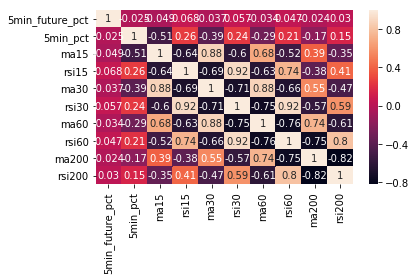

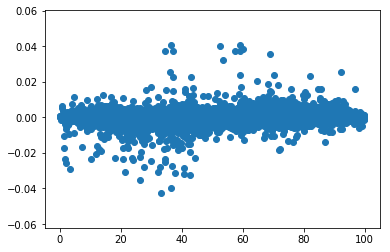

In [9]:
# heatmap of correlation matrix
sns.heatmap(corr, annot=True)
plt.yticks(rotation=0); plt.xticks(rotation=90)  # fix ticklabel directions
plt.tight_layout()  # fits plot area to the plot, "tightly"
plt.show()  # show the plot
plt.clf() # clear the plot area

# scatter plot of the most highly correlated variable with the target
plt.scatter(df['rsi15'], df['5min_future_pct'])
plt.show()

Let's now set up training dataset to be used for preparing some prediction models and compare various performances between models discussed in our class such as decisions trees and k-nearest neighbors. Let's also take a look to see which features have the more importance in strengthening prediction models. 

In [10]:
# Adding a constant to the features
linear_features = sm.add_constant(features)

# size for the training set that is 85% of the number of samples
train_size = int(0.85 * features.shape[0])
train_features = linear_features[:train_size]
train_targets = targets[:train_size]
test_features = linear_features[train_size:]
test_targets = targets[train_size:]
print(linear_features.shape, train_features.shape, test_features.shape)

((53844, 10), (45767, 10), (8077, 10))


C:\ProgramData\Anaconda2\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [11]:
# linear model and least squares fit
model = sm.OLS(train_targets, train_features)
results = model.fit()  
print(results.summary())

# examine pvalues
# Features with p <= 0.05 are typically considered significantly different from 0
print(results.pvalues)

# Make predictions from our model for train and test sets
train_predictions = results.predict(train_features)
test_predictions = results.predict(test_features)

                            OLS Regression Results                            
Dep. Variable:        5min_future_pct   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     52.51
Date:                Fri, 13 Dec 2019   Prob (F-statistic):           1.38e-95
Time:                        11:32:01   Log-Likelihood:             2.2534e+05
No. Observations:               45767   AIC:                        -4.507e+05
Df Residuals:                   45757   BIC:                        -4.506e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0291      0.005      6.367      0.0

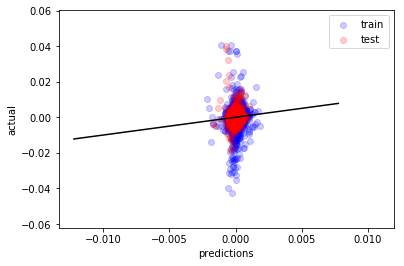

In [12]:
# Scatter the predictions vs the targets with 80% transparency
plt.scatter(train_predictions, train_targets, alpha=0.2, color='b', label='train')
plt.scatter(test_predictions, test_targets, alpha=0.2, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
plt.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k')

# Set the axis labels and show the plot
plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()# show the legend
plt.show()

Let's try a different non-linear machine learning model and begin using decision trees. Decision trees will split our data into groups based on the features (set earlier). We will determine which max_depth can provide the best prediction without overfitting.

In [13]:
from sklearn.tree import DecisionTreeRegressor

# decision tree regression model with default arguments
decision_tree = DecisionTreeRegressor()

# Fit the model to the training features and targets
decision_tree.fit(train_features, train_targets)

# Checking score on train and test
print(decision_tree.score(train_features, train_targets))
print(decision_tree.score(test_features, test_targets))

0.9869864862576161
-1.1495501045921306


A near perfect fit on our training data, but our testing data isn't up to par. 

In [14]:
# Loop through a few different max depths and check the performance
for d in [3,5,10]:
    # fitting decision tree 
    decision_tree = DecisionTreeRegressor(max_depth = d)
    decision_tree.fit(train_features, train_targets)

    # scores on train and test
    print('max_depth=', str(d))
    print(decision_tree.score(train_features, train_targets))
    print(decision_tree.score(test_features, test_targets), '\n')

('max_depth=', '3')
0.022637132863564946
(-0.02124880489764669, '\n')
('max_depth=', '5')
0.03760310283870938
(-0.037156824188978144, '\n')
('max_depth=', '10')
0.14322382770387543
(-0.22340537485400636, '\n')


We can see above that the best fit is a max depth of 3 at a score of -0.02125. Below, we would want to see diagonal lines from the lower left to the upper right. However, due to the simplistic nature of decisions trees, our model is not going to do well on the test set. But it will do well on the train set. As seen below, the predictions group into lines due our limited depth.

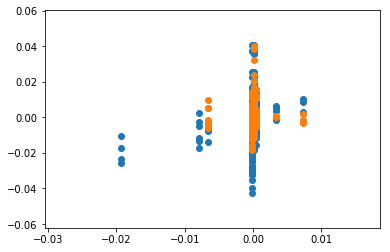

In [15]:
# Using best max_depth of 3 to fit a decision tree
decision_tree = DecisionTreeRegressor(max_depth=3)
decision_tree.fit(train_features, train_targets)

# Prediction values for train and test
train_predictions = decision_tree.predict(train_features)
test_predictions = decision_tree.predict(test_features)

# Scatter the predictions vs actual values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')
plt.show()

Now that we've examined decision trees, let's briefly look at a random forest model. We will use random sample of training data points to test our results. Let's now examine a random forest model and determine its use for prediction on our dataset. Here, a random forest is made up of multiple decision trees (Reference: https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76).

In [16]:
from sklearn.ensemble import RandomForestRegressor

# Create the random forest model and fit to the training data
rfr = RandomForestRegressor(n_estimators=200)
rfr.fit(train_features, train_targets)

# Look at the R^2 scores on train and test
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.8745976757008508
-0.07966337367602461


We could use sklearn's GridSearchCV() method to search hyperparameters, but with a financial time series, we don't want to do cross-validation due to data mixing. We want to fit our models on the oldest data and evaluate on the newest data. So we'll use sklearn's ParameterGrid to create combinations of hyperparameters to search.

In [17]:
from sklearn.model_selection import ParameterGrid

# dictionary of hyperparameters to search
grid = {'n_estimators': [200], 'max_depth': [3], 'max_features': [4, 8], 'random_state': [42]}
test_scores = []

# Loop through parameter grid, set the hyperparameters, and save the scores
for g in ParameterGrid(grid):
    rfr.set_params(**g)  # ** is used to unpack the dictionary
    rfr.fit(train_features, train_targets)
    test_scores.append(rfr.score(test_features, test_targets))

# best hyperparameters from the test score
best_idx = np.argmax(test_scores)
print(test_scores[best_idx], ParameterGrid(grid)[best_idx])

(0.0010660902851407084, {'n_estimators': 200, 'max_features': 4, 'random_state': 42, 'max_depth': 3})


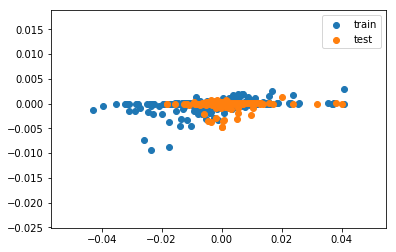

In [18]:
# Using the best hyperparameters from before to fit a random forest model
rfr = RandomForestRegressor(n_estimators=200, max_depth=3, max_features=4, random_state=42)
rfr.fit(train_features, train_targets)

# predictions with our model
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# scatter plot with train/test actual vs predictions
plt.scatter(train_targets, train_predictions, label='train')
plt.scatter(test_targets, test_predictions, label='test')
plt.legend()
plt.show()

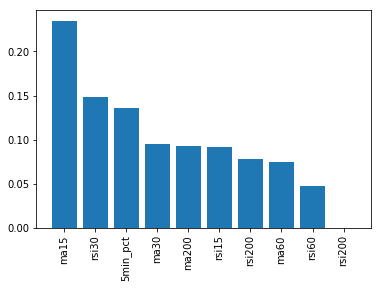

In [19]:
# Get feature importances from our random forest model
importances = rfr.feature_importances_

# Get the index of importances from greatest importance to least
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index-1]
plt.bar(x, importances[sorted_index], tick_label=labels)

# Rotate tick labels to vertical
plt.xticks(rotation=90)
plt.show()

We can see moving average 200 and 15 minutes along with relative strength index 200 minutes as the most contributing features to the predictions. Let's focus on these features to possibly enhance/tune them for even strong predictions.

In [20]:
from sklearn.ensemble import GradientBoostingRegressor

# Create GB model -- hyperparameters have already been searched for you
gbr = GradientBoostingRegressor(max_features=4,
                                learning_rate=0.01,
                                n_estimators=200,
                                subsample=0.6,
                                random_state=42)
gbr.fit(train_features, train_targets)

print(gbr.score(train_features, train_targets))
print(gbr.score(test_features, test_targets))

0.045743334887100806
-0.0005489804798382014


From random forest, the scores for train/test were 0.8733246218778411 and -0.08374728278454358. 

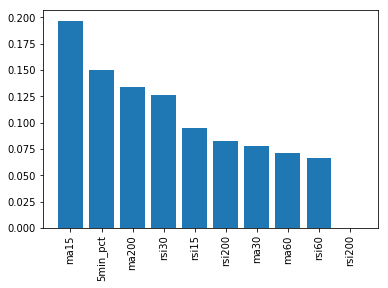

In [21]:
# Extract feature importances from the fitted gradient boosting model
feature_importances = gbr.feature_importances_

# Get the indices of the largest to smallest feature importances
sorted_index = np.argsort(feature_importances)[::-1]
x = range(len(feature_importances))

# Create tick labels 
labels = np.array(feature_names)[sorted_index-1]

plt.bar(x, feature_importances[sorted_index], tick_label=labels)

# tick lables corresponding to feature names 
plt.xticks(rotation=90)
plt.show()

Now let's try k nearest neighbors method. As discussed in lecture, KNN takes the k-nearest points to a new point and averages their target values to obtain a prediction. By implementing scale() method, we will try normalizing the data so the features have similar ranges.

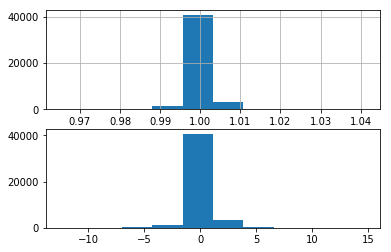

('n_neighbors =', 30)
train, test scores
0.10782220799700026
-0.013995328953734454
()
('n_neighbors =', 31)
train, test scores
0.10514583128183375
-0.016980153515271157
()
('n_neighbors =', 32)
train, test scores
0.1039407977744532
-0.014317057907725417
()
('n_neighbors =', 33)
train, test scores
0.10043221657940804
-0.014470602720116466
()
('n_neighbors =', 34)
train, test scores
0.09858075168241198
-0.01264357622191592
()
('n_neighbors =', 35)
train, test scores
0.09630948922517257
-0.01273101911610275
()
('n_neighbors =', 36)
train, test scores
0.09406456360023208
-0.01318752638125309
()
('n_neighbors =', 37)
train, test scores
0.0920245073829623
-0.013343701836921351
()


In [22]:
from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsRegressor

# Standardize the train and test features
scaled_train_features = scale(train_features)
scaled_test_features = scale(test_features)

# histogram before and after scaling (model might work better with dataset spread over different timeframe)
f, ax = plt.subplots(nrows=2, ncols=1)
train_features.iloc[:, 2].hist(ax=ax[0])
ax[1].hist(scaled_train_features[:, 2])
plt.show()

for n in range(30, 38):
    # fitting the KNN model
    knn = KNeighborsRegressor(n_neighbors=n)
    
    # Fitting model to the training data
    knn.fit(scaled_train_features, train_targets)
    
    # number of neighbors score of best value of n 
    print("n_neighbors =", n)
    print('train, test scores')
    print(knn.score(scaled_train_features, train_targets))
    print(knn.score(scaled_test_features, test_targets))
    print()  # prints a blank line

After plugging and testing a various range of values, we can choose n-neighbors 34 for optimal model. 

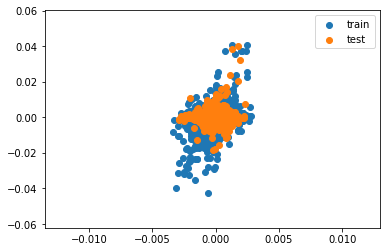

In [23]:
# model with the best-performing n_neighbors of 34
knn = KNeighborsRegressor(n_neighbors=34)

# Fit the model
knn.fit(scaled_train_features, train_targets)

# predictions for train and test sets
train_predictions = knn.predict(scaled_train_features)
test_predictions = knn.predict(scaled_test_features)

# plotting actual vs predicted values
plt.scatter(train_predictions, train_targets, label='train')
plt.scatter(test_predictions, test_targets, label='test')
plt.legend()
plt.show()